The goal of this project is to familiarize ourselves with the fundamentals of deep learning engineering for computer vision and image recognition. We will reimplement from scratch the ResNet family of vision models, and apply our model to classify images into different categories.

We will start by loading an existing ResNet implementation (pretrained on ImageNet), and seeing what sorts of classificaton the model can output. Then, we will discuss and implement the basic blocks of computer vision architectures. After that, we will move to ResNet, and implement the architecture using our basic blocks. We will then use our model for classifying images, and use interpretability techniques to analyse its internals.

# Prelude: image classifications from a pretrained ResNet

First, we load a pretrained ResNet model from the PyTorch vision repository.

In [10]:
from torchvision import models
torchvision_resnet34 = models.resnet34(pretrained=True)
resnet34 = torchvision_resnet34
_ = resnet34.eval()

We will download images from the internet to feed into the model.

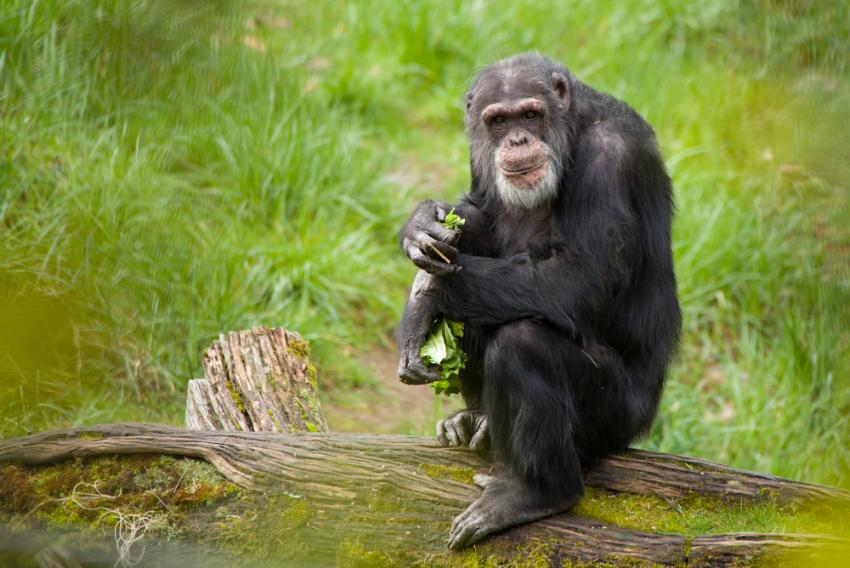

In [11]:
from PIL import Image
import requests
from io import BytesIO

def load_image(url):
  response = requests.get(url)
  return Image.open(BytesIO(response.content))

url = "https://www.oregonzoo.org/sites/default/files/styles/article-full/public/animals/H_chimpanzee%20Jackson.jpg"
img = load_image(url)
img

The model expects a batch of images of shape `(num_images, num_channels=3, height, width)`, and outputs the [classfication logits](https://developers.google.com/machine-learning/glossary/#logits) of shape `(num_images, num_classes=1000)`.

In [12]:
import torch
from torchvision import transforms

inputs = transforms.ToTensor()(img).unsqueeze_(0)
print(inputs.shape)
outputs = resnet34(inputs)
print(outputs.shape)

torch.Size([1, 3, 568, 850])
torch.Size([1, 1000])


We load the ImageNet class [labels](https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt).

In [13]:
imagenet_labels_url = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'
response = requests.get(imagenet_labels_url)
imagenet_labels = eval(response.text)

We select a few random images from the internet, and check the classification results from the model, by looking at the most likely and least likely predicted classes.

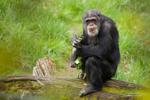

05.10% | chimpanzee, chimp, Pan troglodytes
01.48% | siamang, Hylobates syndactylus, Symphalangus syndactylus
01.32% | langur
...
00.00350% | pomegranate
00.00344% | rotisserie
00.00322% | admiral



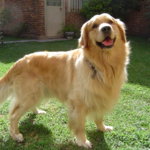

26.91% | golden retriever
05.63% | Great Pyrenees
04.29% | collie
...
00.00061% | gyromitra
00.00059% | stinkhorn, carrion fungus
00.00054% | bolete



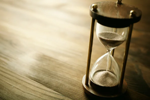

97.92% | hourglass
00.08% | beaker
00.07% | guillotine
...
00.00003% | sea slug, nudibranch
00.00003% | pickup, pickup truck
00.00003% | flatworm, platyhelminth



KeyboardInterrupt: 

In [14]:
urls = [
  "https://www.oregonzoo.org/sites/default/files/styles/article-full/public/animals/H_chimpanzee%20Jackson.jpg",
  "https://anipassion.com/ow_userfiles/plugins/animal/breed_image_56efffab3e169.jpg",
  "https://static5.depositphotos.com/1017950/406/i/600/depositphotos_4061551-stock-photo-hourglass.jpg",
  "https://img.nealis.fr/ptv/img/p/g/1465/1464424.jpg",
  "http://www.tudobembresil.com/wp-content/uploads/2015/11/nouvelancopacabana.jpg",
  "https://ychef.files.bbci.co.uk/976x549/p0639ffn.jpg",
  "https://www.thoughtco.com/thmb/Dk3bE4x1qKqrF6LBf2qzZM__LXE=/1333x1000/smart/filters:no_upscale()/iguana2-b554e81fc1834989a715b69d1eb18695.jpg",
  "https://i.redd.it/mbc00vg3kdr61.jpg",
  "https://static.wikia.nocookie.net/disneyfanon/images/a/af/Goofy_pulling_his_ears.jpg",
]

def show_classes_probabilities(k=3):
  for url in urls:
    img = load_image(url)

    inputs = transforms.ToTensor()(img).unsqueeze_(0)
    outputs = resnet34(inputs)
    probs = torch.softmax(outputs, -1).flatten()
    sorted_probs, sorted_idxs = probs.sort(descending=True)
    sorted_probs = [p.item() for p in sorted_probs]
    sorted_classes = [imagenet_labels[idx.item()] for idx in sorted_idxs]

    small_img = img.copy()
    small_img.thumbnail((150, 150))
    display(small_img)
    print(
      *(f'{100*prob:05.2f}% | {label}' for prob, label in zip(sorted_probs[:k], sorted_classes[:k])),
      '...',
      *(f'{100*prob:08.5f}% | {label}' for prob, label in zip(sorted_probs[-k:], sorted_classes[-k:])),
      sep='\n',
      end='\n\n',
    )

show_classes_probabilities()

### Step: adding images

Now it's your turn! Add a few urls below, and check what their classifications are.

In [ ]:
urls = [
]

show_classes_probabilities()

# Implementing ResNet building blocks

We now start implementing our own ResNet model.

## Operating on tensors: as_strided and einsum

To implement some of our building blocks, we will use the following functions:
* `torch.einsum`: implements summations over tensor indices using Einstein notation. You can read more about it here:
    * https://pytorch.org/docs/stable/generated/torch.einsum.html
    * https://ajcr.net/Basic-guide-to-einsum/
* `torch.as_strided`: PyTorch tensors data are physically stored as 1-d arrays, and the shape and stride abstractions describe a multidimensional indexing API into this data. The shape (or size) is an N-tuple describing the number of valid indices for each dimension. The stride is an N-tuple corersponding to how many cells to jump in the 1-d physical array when the index of each dimension is incremented. The function `.as_strided` can then be used to change the shape and stride of a tensor without changing the underlying data. This can be used to efficiently implement many operations on tensors. You can read more about it here:
    * https://pytorch.org/docs/stable/generated/torch.as_strided.html
    * https://jott.live/markdown/as_strided
    
We will start this section by familiarizing ourselves with these functions by reimplementing some matrix operations.

### Step: as_strided arguments

For each test case below, change the arguments `size` and `stride`, so that a call of `torch.as_strided(test_input_a, size=size, stride=stride)` matches the desired output.

In [ ]:
from collections import namedtuple

test_input_a = torch.tensor([[ 0,  1,  2,  3,  4],
                             [ 5,  6,  7,  8,  9],
                             [10, 11, 12, 13, 14],
                             [15, 16, 17, 18, 19]])

TestCase = namedtuple('TestCase', ['output', 'size', 'stride'])

test_cases = [
  TestCase(
    output=torch.tensor([0, 1, 2, 3]),
    size=(1,),
    stride=(1,),
  ),
  TestCase(
    output=torch.tensor([[0, 1, 2],
                         [5, 6, 7]]),
    size=(1,),
    stride=(1,),
  ),
  TestCase(
    output=torch.tensor([[0, 0, 0],
                         [11, 11, 11]]),
    size=(1,),
    stride=(1,),
  ),
  TestCase(
    output=torch.tensor([0, 6, 12, 18]),
    size=(1,),
    stride=(1,),
  ),
  TestCase(
    output=torch.tensor([[[0, 1, 2],
                          [9, 10, 11]]]),
    size=(1,),
    stride=(1,),
  ),
  TestCase(
    output=torch.tensor([[[[0, 1],
                           [2, 3]],
                          [[4, 5],
                           [6, 7]]],
                         [[[12, 13],
                           [14, 15]],
                          [[16, 17],
                           [18, 19]]]]),
    size=(1,),
    stride=(1,),
  ),
]

In [ ]:
#@title Reference { form-width: "100px" }

test_cases = [
  TestCase(
    output=torch.tensor([0, 1, 2, 3]),
    size=(4,),
    stride=(1,),
  ),
  TestCase(
    output=torch.tensor([[0, 1, 2],
                         [5, 6, 7]]),
    size=(2, 3),
    stride=(5, 1),
  ),
  TestCase(
    output=torch.tensor([[0, 0, 0],
                         [11, 11, 11]]),
    size=(2, 3),
    stride=(11, 0),
  ),
  TestCase(
    output=torch.tensor([0, 6, 12, 18]),
    size=(4,),
    stride=(6,),
  ),
  TestCase(
    output=torch.tensor([[[0, 1, 2]],
                         [[9, 10, 11]]]),
    size=(2, 1, 3),
    stride=(9, 0, 1),
  ),
  TestCase(
    output=torch.tensor([[[[0, 1],
                           [2, 3]],
                          [[4, 5],
                           [6, 7]]],
                         [[[12, 13],
                           [14, 15]],
                          [[16, 17],
                           [18, 19]]]]),
    size=(2, 2, 2, 2),
    stride=(12, 4, 2, 1),
  ),
]

In [15]:
def is_equal_test(*, output, expected, test_name='Test'):
  successful = torch.allclose(expected.to(float), output.to(float))
  if successful:
    print(f'{test_name} passed!')
  else:
    print(f'{test_name} failed')
    print(f'Output:\n{output}')
    print(f'Expected:\n{expected}')

for i, (expected, size, stride) in enumerate(test_cases):
  output = torch.as_strided(test_input_a, size=size, stride=stride)
  is_equal_test(test_name=i, output=output, expected=expected)

NameError: name 'test_cases' is not defined

### Step: as_strided trace

Implement a function that receives a square matrix (as a 2d tensor) and returns its [trace](https://en.wikipedia.org/wiki/Trace_(linear_algebra)) using `torch.as_strided` and `torch.sum`



In [ ]:
def strided_trace(a):
  pass

In [ ]:
#@title Reference { form-width: "100px" }

def strided_trace(a):
  N, _ = a.shape
  a_strided = torch.as_strided(a, size=(N,), stride=(N+1,))
  return torch.sum(a_strided)

def einsum_trace(a):
  return torch.einsum('ii->', a)

a = torch.randn(10, 10)
assert torch.allclose(strided_trace(a), einsum_trace(a), rtol=1e-4, atol=1e-4)

### Step: as_strided matmul

Implement a function that receives two matrices (as 2d tensors) and returns their [multiplication](https://en.wikipedia.org/wiki/Matrix_multiplication), using `torch.as_strided`, `torch.sum`, and elementwise multiplication.

In [ ]:
def strided_matmul(a, b):
  pass

In [ ]:
#@title Reference { form-width: "100px" }

def strided_matmul(a, b):
  N, K = a.shape
  K, M = b.shape
  a_strided = torch.as_strided(a, size=(N, K, M), stride=(K, 1, 0))
  b_strided = torch.as_strided(b, size=(N, K, M), stride=(0, M, 1))
  return torch.sum(torch.mul(a_strided, b_strided), 1)

def einsum_matmul(a, b):
  return torch.einsum('ik,kj->ij', a, b)

a = torch.randn(10, 5)
b = torch.randn(5, 15)
assert torch.allclose(strided_matmul(a, b), einsum_matmul(a, b), rtol=1e-4, atol=1e-4)

## Convolutions and pooling

Convolutions are one of the fundamental operations of signal processing. It can be interpreted as a sliding window that goes over all positions of the input, and outputs a weighted sum of the values of the region.

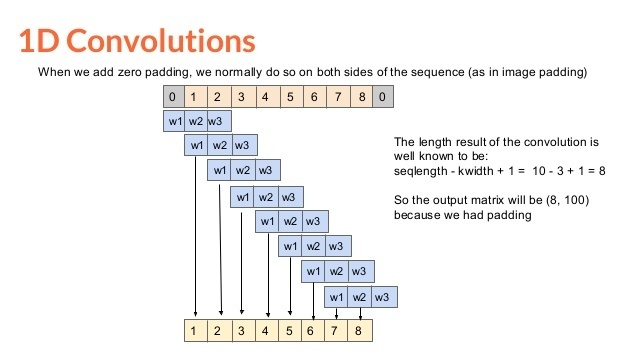

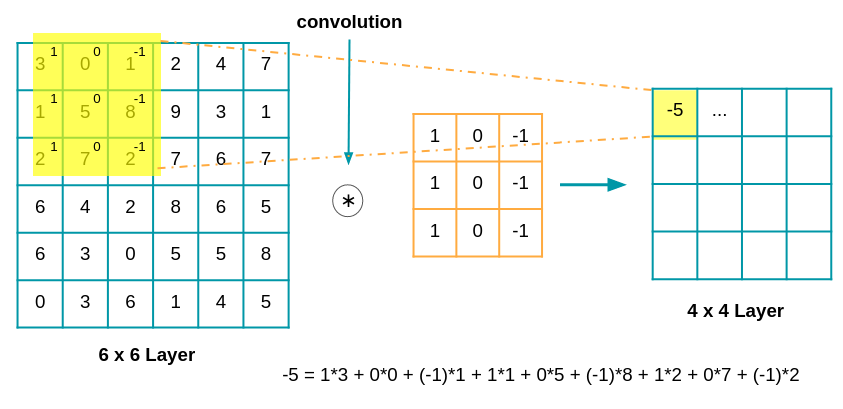

A 1-d convolution is can be written as:
$$\operatorname{conv1d}(input, weights, bias)[b, c_o, i] = \sum_{c_i = 0}^{C_i} \sum_{di = 0}^{k-1} weights[c_o, c_i, di] \cdot input[b, c_i, i+di] + \operatorname{bias}[c_o]$$

A 2-d convolution can be written as:
$$\operatorname{conv2d}(input, weights, bias)[b, c_o, i, j] = \sum_{c_i = 0}^{C_i} \sum_{di = 0}^{k_h-1}\sum_{dj = 0}^{k_w-1} weights[c_o, c_i, di, dj] \cdot input[b, c_i, i+di, j+dj] + bias[c_0]$$

One way to think about convolutions is that convolutions are the linear translation invariant functions. That is, if F is a function, and the following holds:
* $F(x + y) = F(x) + F(y)$
* $F(T(x)) = T(F(x))$ (where $T$ corresponds to shifting the input)

Then $F$ can be written as a convolution.

### Step: conv1d arguments

To get familiarity with `conv1d`, replace the indicated variables to pass the tests below.

In [16]:
from torch.nn.functional import conv1d as torch_conv1d
from torch.nn.functional import conv2d as torch_conv2d

Replace `weights` to pass the test.

In [ ]:
input = torch.tensor([[[1, 2, 3, 4]]])
weights = torch.tensor([[[0, 0]]])
# weights = torch.tensor([[[1, 3]]]) # answer
output = torch_conv1d(input, weights)
expected = torch.tensor([7.0, 11.0, 15.0])
is_equal_test(output=output, expected=expected)

Test failed
Output:
tensor([[[0, 0, 0]]])
Expected:
tensor([ 7., 11., 15.])


Replace `input` to pass the test.

In [ ]:
input = torch.tensor([[[1, 1, 1, 1, 1, 1, 1, 1]]])
# input = torch.tensor([[[100, 15, -5, 0, 1, 2, 3, 4]]]) # answer
weights = torch.tensor([[[2, 0, -2]]])
output = torch_conv1d(input, weights)
expected = torch.tensor([[[210, 30, -12, -4, -4, -4]]])
is_equal_test(output=output, expected=expected)

Test failed
Output:
tensor([[[0, 0, 0, 0, 0, 0]]])
Expected:
tensor([[[210,  30, -12,  -4,  -4,  -4]]])


Replace `weights` to pass the test.

In [ ]:
input = torch.tensor([[[1, 2, 3],
                       [4, 5, 6]],
                      [[1, 1, 1],
                       [2, 3, 2]]])
weights = torch.tensor([[[0], [0]]]) 
# weights = torch.tensor([[[1], [2]]]) # answer
output = torch_conv1d(input, weights)
expected = torch.tensor([[[9, 12, 15]],
                         [[5, 7, 5]]])
is_equal_test(output=output, expected=expected)

Test failed
Output:
tensor([[[0, 0, 0]],

        [[0, 0, 0]]])
Expected:
tensor([[[ 9, 12, 15]],

        [[ 5,  7,  5]]])


### Step: conv1d

Implement 1d convolutions using `torch.as_strided` and `torch.einsum`.

In [ ]:
def conv1d(x, weights, bias=None):
  pass

In [30]:
#@title Reference { form-width: "100px" }

def conv1d(x, weights, bias=None):
  if bias is None:
    bias = torch.tensor(0.0)
  B, xC, xL = x.shape
  oC, _, kL = weights.shape
  oL = xL - kL + 1
  bs, cs, ls = x.stride() # typically, (iC*iW, iW, 1)
  conv_size = (B, xC, oL, kL)
  conv_stride = (bs, cs, ls, ls)
  strided_x = torch.as_strided(x, size=conv_size, stride=conv_stride)
  return torch.einsum('bcxi,oci->box', strided_x, weights) + bias.unsqueeze(-1)


In [31]:
def test_conv1d_minimal(my_conv, n_tests=10):
  import numpy as np
  for i in range(n_tests):
    b = np.random.randint(1, 10)
    h = np.random.randint(10, 300)
    ci = np.random.randint(1, 20)
    co = np.random.randint(1, 20)
    kernel_size = np.random.randint(1, 10)

    x = torch.randn((b, ci, h))
    weights = torch.randn((co, ci, kernel_size))
    bias = torch.randn((co,))

    my_output = my_conv(
      x,
      weights,
      bias=bias,
    )

    torch_output = torch.conv1d(
      x,
      weights,
      stride=1,
      padding=0,
      bias=bias,
    )

    if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
      print(f'Conv1d (minimal) test {i} failed.')
      print(f"Expected {torch_output.flatten()[:5]}...,")
      print(f"Got {my_output.flatten()[:5]}...")
      return
    print(f"Test {i} passed!")
  print('All tests passed!')

test_conv1d_minimal(conv1d)

Test 0 passed!
Test 1 passed!
Test 2 passed!
Test 3 passed!
Test 4 passed!
Test 5 passed!
Test 6 passed!
Test 7 passed!
Test 8 passed!
Test 9 passed!
All tests passed!


### Step: conv2d

Implement 2d convolutions (with minimal arguments). Use `torch.as_strided` and `torch.einsum`.

In [ ]:
def conv2d(x, weights, bias=None):
  pass

In [27]:
#@title Reference { form-width: "100px" }

def conv2d(x, weights, bias=None):
  if bias is None:
    bias = torch.tensor(0.0)
  B, iC, iH, iW = x.shape
  oC, _, kH, kW = weights.shape
  oH = iH - kH + 1
  oW = iW - kW + 1
  bs, cs, hs, ws = x.stride()
  conv_size = (B, iC, oH, oW, kH, kW)
  conv_stride = (bs, cs, hs, ws, hs, ws)
  strided_x = torch.as_strided(x, size=conv_size, stride=conv_stride)
  return torch.einsum('bcxyij,ocij->boxy', strided_x, weights) + bias.reshape(-1, 1, 1)
  

In [29]:
def test_conv2d_minimal(my_conv, n_tests=10):
  import numpy as np

  for i in range(n_tests):
    b = np.random.randint(1, 10)
    h = np.random.randint(10, 300)
    w = np.random.randint(10, 300)
    ci = np.random.randint(1, 20)
    co = np.random.randint(1, 20)
    kernel_size = tuple(np.random.randint(1, 10, size=(2,)))

    x = torch.randn((b, ci, h, w))
    weights = torch.randn((co, ci, *kernel_size))
    bias = torch.randn((co,))

    my_output = my_conv(
      x,
      weights,
      bias=bias,
    )

    torch_output = torch.conv1d(
      x,
      weights,
      stride=1,
      padding=0,
      bias=bias,
    )

    if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
      print(f'Conv2d (minimal) test {i} failed.')
      print(f"Expected {torch_output.flatten()[:5]}...,")
      print(f"Got {my_output.flatten()[:5]}...")
      return
    print(f"Test {i} passed!")
  print('All tests passed!')

test_conv2d_minimal(conv2d)


Test 0 passed!
Test 1 passed!
Test 2 passed!
Test 3 passed!
Test 4 passed!
Test 5 passed!
Test 6 passed!
Test 7 passed!
Test 8 passed!
Test 9 passed!
All tests passed!


### Step: stride and padding

Convolutions generally take a few extra arguments, such as:
* `stride`: how many positions to increment in the input for each position increment in the output. Useful for downsampling the input.
* `padding`: pads the input with $p$ zeroes on each side before applying the convolution. Useful for controlling the output size.

Add `stride` and `padding` parameters to your implementations of `conv1d`, `conv2d`.

In [ ]:
def conv1d(x, weights, stride=1, padding=0, bias=None):
  pass

def conv2d(x, weights, stride=1, padding=0, bias=None):
  pass
    

In [33]:
#@title Reference { form-width:"100px" }
from torch.nn.functional import pad # to reimplement pad

def conv1d(x, weights, stride=1, padding=0, bias=None):
  if bias is None:
    bias = torch.tensor(0.0)
  B, iC, iH = x.shape
  oC, _, kH = weights.shape
  oH = (iH + 2*padding - kH) // stride + 1

  padded_x = pad(x, [padding, padding])
  conv_size = (B, iC, oH, kH)
  bs, cs, hs = padded_x.stride()
  conv_stride = (bs, cs, hs*stride, hs) 
  strided_x = torch.as_strided(padded_x, size=conv_size, stride=conv_stride)

  return torch.einsum('bcxi,oci->box', strided_x, weights) + bias.unsqueeze(-1)

def force_pair(v):
  return v if isinstance(v, tuple) else (v, v)

def conv2d(x, weights, stride=1, padding=0, bias=None):
  if bias is None:
    bias = torch.tensor(0.0)
  sH, sW = force_pair(stride)
  pH, pW = force_pair(padding)
  B, iC, iH, iW = x.shape
  oC, _, kH, kW = weights.shape
  oH = (iH + 2*pH - kH) // sH + 1
  oW = (iW + 2*pW - kW) // sW + 1

  padded_x = pad(x, [pW, pW, pH, pH])

  conv_size = (B, iC, oH, oW, kH, kW)
  bs, cs, hs, ws = padded_x.stride()
  conv_stride = (bs, cs, hs*sH, ws*sW, hs, ws)
  strided_x = torch.as_strided(padded_x, size=conv_size, stride=conv_stride)

  return torch.einsum('bcxyij,ocij->boxy', strided_x, weights) + bias.reshape(-1, 1, 1)


In [34]:
#@title conv2d fuzz tests { form-width:"200px" }

# Fuzz test

def test_conv1d(my_conv, n_tests = 10):
  import numpy as np

  for i in range(n_tests):
    b = np.random.randint(1, 10)
    h = np.random.randint(10, 300)
    ci = np.random.randint(1, 20)
    co = np.random.randint(1, 20)
    stride = np.random.randint(1, 5)
    padding = np.random.randint(1, 5)
    kernel_size = np.random.randint(1, 10)

    x = torch.randn((b, ci, h))
    weights = torch.randn((co, ci, kernel_size))
    bias = torch.randn((co,))

    my_output = my_conv(
      x,
      weights,
      stride=stride,
      padding=padding,
      bias=bias,
    )

    torch_output = torch.conv1d(
      x,
      weights,
      stride=stride,
      padding=padding,
      bias=bias,
    )

    if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
      print(f'Conv1d test {i} failed.')
      print(f"Expected {torch_output.flatten()[:5]}...,")
      print(f"Got {my_output.flatten()[:5]}...")
      return
    print(f"Test {i} passed!")
  print('All tests passed!')

test_conv1d(conv1d)

def test_conv2d(my_conv, n_tests = 10):
  import numpy as np
  for i in range(n_tests):
    b = np.random.randint(1, 10)
    h = np.random.randint(10, 300)
    w = np.random.randint(10, 300)
    ci = np.random.randint(1, 20)
    co = np.random.randint(1, 20)

    stride = tuple(np.random.randint(1, 5, size=(2,)))
    padding = tuple(np.random.randint(1, 5, size=(2,)))
    kernel_size = tuple(np.random.randint(1, 10, size=(2,)))

    x = torch.randn((b, ci, h, w))
    weights = torch.randn((co, ci, *kernel_size))
    bias = torch.randn((co,))

    my_output = my_conv(
      x,
      weights,
      stride=stride,
      padding=padding,
      bias=bias,
    )

    torch_output = torch.conv2d(
      x,
      weights,
      stride=stride,
      padding=padding,
      bias=bias,
    )

    if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
      print(f'Conv2d test {i} failed.')
      print(f"Expected {torch_output.flatten()[:5]}...,")
      print(f"Got {my_output.flatten()[:5]}...,")
      return
    print(f"Test {i} passed!")

  print('All tests passed!')

test_conv2d(conv2d)


Test 0 passed!
Test 1 passed!
Test 2 passed!
Test 3 passed!
Test 4 passed!
Test 5 passed!
Test 6 passed!
Test 7 passed!
Test 8 passed!
Test 9 passed!
All tests passed!
Test 0 passed!
Test 1 passed!
Test 2 passed!
Test 3 passed!
Test 4 passed!
Test 5 passed!
Test 6 passed!
Test 7 passed!
Test 8 passed!
Test 9 passed!
All tests passed!


### Step: maxpool2d

Poolings have the same format as convolutions - only that instead of outputting a weighted sum, max poolings output the maximum value of the window, and average poolings output the average.

Implement 2d max pooling using `torch.as_strided` and `torch.amax`.


In [ ]:
def maxpool2d(inputs, kernel_size):
  pass

In [ ]:
#@title Reference { form-width: "100px" }

def maxpool2d(x, kernel_size, stride=None, padding=0):
  if stride is None:
    stride = kernel_size
  B, iC, iH, iW = x.shape
  kH, kW = force_pair(kernel_size)
  sH, sW = force_pair(stride)
  pH, pW = force_pair(padding)
  oH = (iH + 2*pH - kH) // sH + 1
  oW = (iW + 2*pW - kW) // sW + 1

  padded_x = pad(x, [pW, pW, pH, pH], value=-float('inf'))

  conv_size = (B, iC, oH, oW, kH, kW)
  bs, cs, hs, ws = padded_x.stride()
  conv_stride = (bs, cs, hs*sH, ws*sW, hs, ws)
  strided_x = torch.as_strided(padded_x, size=conv_size, stride=conv_stride)

  return strided_x.amax((-2, -1))

In [ ]:
#@title maxpool2d fuzz tests { form-width: "200px" }

from torch.nn.functional import max_pool2d as torch_maxpool2d

# Fuzz test
def test_maxpool():
  import numpy as np

  n_tests = 100
  for i in range(n_tests):
    b = np.random.randint(1, 10)
    h = np.random.randint(10, 300)
    w = np.random.randint(10, 300)
    ci = np.random.randint(1, 20)

    none_stride = bool(np.random.randint(2))
    if none_stride:
      stride = None
    else:
      stride = tuple(np.random.randint(1, 5, size=(2,)))
    kernel_size = tuple(np.random.randint(1, 10, size=(2,)))
    kH, kW = kernel_size
    padding = np.random.randint(0, 1 + kH//2), np.random.randint(0, 1 + kW//2)

    x = torch.randn((b, ci, h, w))

    my_output = maxpool2d(
      x,
      kernel_size,
      stride=stride,
      padding=padding,
    )

    torch_output = torch_maxpool2d(
      x,
      kernel_size,
      stride=stride,
      padding=padding,
    )
    if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
      print('A test failed!')
      print('input:')
      print(x)
      print('----------')
      print('output:')
      print(my_output)
      print('expected:')
      print('----------')
      print(torch_output)
      return

  print('All tests passed!')

test_maxpool()


All tests passed!


### Step: Conv2d, MaxPool2d Modules

Implement now Conv2d and MaxPool2d Modules, making use of your functions conv2d and maxpool2d in the forward pass.

For initializing the values of the Conv2d parameters, read [this](https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79)

[Provide short explanation inplace]

In [ ]:
from torch.nn import Module, Parameter

In [ ]:
class Conv2d(Module):
  def __init__(
    self,
    in_channels,
    out_channels,
    kernel_size,
    stride=1,
    padding=0,
    bias=True,
  ):
    pass

  def forward(self, x):
    pass
    

class MaxPool2d(Module):
  def __init__(
    self,
    kernel_size,
    stride=None,
    padding=1,
  ):
    pass

  def forward(self, x):
    pass


In [ ]:
#@title Reference { form-width:"100px" }

import math
import numpy as np

def prod(seq):
  from functools import reduce
  from operator import mul
  return reduce(mul, seq, 1)

class Conv2d(Module):
  def __init__(
    self,
    in_channels,
    out_channels,
    kernel_size,
    stride=1,
    padding=0,
    bias=True,
  ):
    kernel_size = force_pair(kernel_size)
    self.stride = force_pair(stride)
    self.padding = force_pair(padding)

    super().__init__()
    weight_size = (out_channels, in_channels, *kernel_size)
    bound = 1 / math.sqrt(weight_size[1] * prod(kernel_size))
    self.weight = Parameter(torch.FloatTensor(*weight_size).uniform_(-bound, bound))

    if bias:
      fan_in = prod(self.weight.shape[1:])
      bound = 1 / math.sqrt(fan_in)
      self.bias = Parameter(torch.FloatTensor(out_channels).uniform_(-bound, bound))
    else:
      self.bias = torch.zeros(out_channels)


  def forward(self, x):
    return conv2d(
      x,
      self.weight,
      stride=self.stride,
      padding=self.padding,
      bias=self.bias,
    )


class MaxPool2d(Module):
  def __init__(
    self,
    kernel_size,
    stride=None,
    padding=1,
  ):
    super().__init__()
    if stride is None:
      stride = kernel_size

    self.kernel_size = force_pair(kernel_size)
    self.stride = force_pair(stride)
    self.padding = force_pair(padding)

  def forward(self, x):
    return maxpool2d(
      x,
      self.kernel_size,
      stride=self.stride,
      padding=self.padding,
    )


## Batch Normalization

[Add inplace explanation]

Read more about batch normalization [here](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739).

### Step: BatchNorm2d

Implement a BatchNorm2d module.

In [ ]:
class BatchNorm2d(Module):
  def __init__(
    self,
    num_features,
    eps=1e-5,
    momentum=0.1,
  ):
    pass

  def forward(self, x):
    pass

In [ ]:
#@title Reference { form-width:"100px"}

class BatchNorm2d(Module):
  def __init__(
    self,
    num_features,
    eps=1e-5,
    momentum=0.1,
  ):
    super().__init__()
    self.eps = eps
    self.momentum = momentum
    self.weight = Parameter(torch.ones(num_features))
    self.bias = Parameter(torch.zeros(num_features))
    self.register_buffer('running_mean', torch.zeros(num_features))
    self.register_buffer('running_var', torch.ones(num_features))
    self.register_buffer('num_batches_tracked', torch.tensor(0))

  def forward(self, x):
    ids = (0, 2, 3)
    if self.training:
      mean = x.mean(ids)
      var = x.var(ids, unbiased=False)
      a = self.momentum
      self.running_mean.data = (1 - a) * self.running_mean.data + a * mean
      self.running_var.data = (1 - a) * self.running_var.data + a * var
      self.num_batches_tracked.data += 1
    else:
      mean = self.running_mean
      var = self.running_var

    rs = lambda u : u.reshape(1, -1, 1, 1)
    return rs(self.weight) * (x - rs(mean)) / torch.sqrt(rs(var) + self.eps) + rs(self.bias)

# Assembling your ResNet

ResNet motivation
* Explain basics of vision architectures
    * input processing
    * conv + batchnorm + relu
    * progressively reduce dimensions and increase features
    * fully connected layer at the end
* Residual blocks: easier to propagate signals over many layers of identity + noise, than to propagate signals over many layers of noise

[ResNet paper](https://arxiv.org/abs/1512.03385)


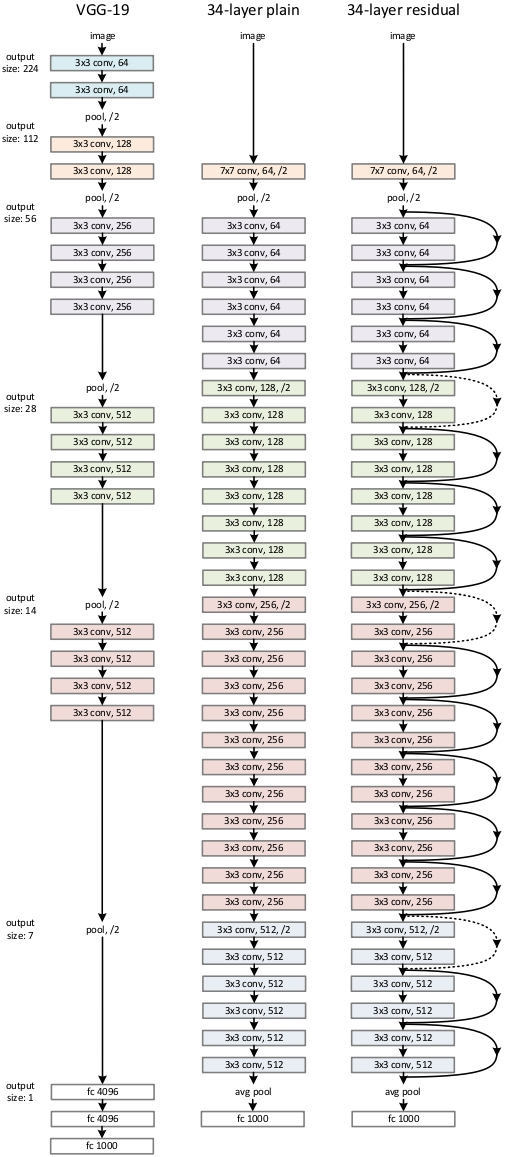

The ResNet architecture can be seen on the right of the figure above. Here is how to interpret it:
* every convolution is followed by a batch norm and a relu;
* "/2" means the height and width are halved (they are kept the same otherwise)
  * the padding is always $p = \frac{k-1}{2}$ (this is known as ["same" padding](https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t), because it keeps the same size when the stride is 1)
  * the stride is 2 when there is a "/2", and 1 otherwise
* $k \times k$ conv, $N$ represents a block of conv+batchnorm+relu, where $k$ is the conv kernel size and $N$ is the number of output channels
* side arrows mean that the input is added before the relu at the output
  * bold arrows: output size equals input size, and input is added as is
  * dotted arrows: output height/width is half of the input, and double in features; in this case we downsample the input, passing it through a conv of kernel size 1 and stride 2;
* the "avg pool" here means a layer with input $(B, C, H, W)$ and output $(B, C, 1)$, where values over height and width dimensions are averaged out into a single value

### Step: Residual block

Start by implementing a residual block (i.e. 2x conv+batchnorm+relu, and a residual connection; the number of input and output channels can vary; whether the output size is the same or is halved can also vary).

In [ ]:
class ResidualBlock(Module):
  def __init__(self, in_feats, out_feats, downsample=False):
    pass

  def forward(self, x):
    pass

In [ ]:
#@title Reference { form-width:"100px"}

# to import
def relu(tensor):
  tensor[tensor < 0] = 0
  return tensor

class ReLU(Module):
  def forward(self, x):
    return relu(x)


# they can just use .flatten() instead
class Flatten(Module):
  def __init__(self, start_dim=1, end_dim=-1):
    super().__init__()
    self.start_dim = start_dim
    self.end_dim = end_dim

  def forward(self, x):
    return x.flatten(self.start_dim, self.end_dim)


# they should just use .mean((-2, -1)) instead
class AdaptiveAvgPool2d(Module):
  def __init__(self, output_size):
    super().__init__()
    self.output_size = force_pair(output_size)

  def forward(self, x):
    def kernels(in_dim, out_dim):
      return [slice(math.floor((i * in_dim) / out_dim),
          math.ceil(((i + 1) * in_dim) / out_dim))
        for i in range(out_dim)]

    B, C, iH, iW = x.shape
    oH, oW = self.output_size

    kHs = kernels(iH, oH)
    kWs = kernels(iW, oW)

    out = torch.empty((B, C, oH, oW))
    for i, ker_H in enumerate(kHs):
      for j, ker_W in enumerate(kWs):
        out[:, :, i, j] = torch.mean(x[:, :, ker_H, ker_W], (-2, -1))
    return out

# To import
class Linear(Module):
  def __init__(self, x, y, bias=True):
    super(Linear, self).__init__()
    weight_bound = 1 / np.sqrt(x)
    self.weight = Parameter(torch.FloatTensor(y, x).uniform_(-weight_bound, weight_bound))
    if bias:
      bias_bound = 1 / np.sqrt(y)
      self.bias = Parameter(torch.FloatTensor(y).uniform_(-bias_bound, bias_bound))
    else:
      self.bias = None

  def forward(self, x):
    x = torch.einsum("...j,kj->...k", x, self.weight)
    if self.bias is not None:
      x += self.bias
    return x


In [ ]:
#@title Reference { form-width:"100px"}

from torch.nn import Sequential
from torch import nn

class ResidualBlock(Module):
  def __init__(self, in_feats, out_feats, stride=1):
    super().__init__()
    self.net = Sequential(
      Conv2d(in_feats, out_feats, kernel_size=3, stride=stride, padding=1, bias=False),
      BatchNorm2d(out_feats),
      ReLU(),
      Conv2d(out_feats, out_feats, kernel_size=3, padding=1, bias=False),
      BatchNorm2d(out_feats),
    )
    self.downsample = (
      Sequential(
      Conv2d(in_feats, out_feats, kernel_size=1, stride=stride, bias=False),
      BatchNorm2d(out_feats),
      )
      if stride != 1
      else None
    )

  def forward(self, x):
    y_out = self.net(x)
    x_out = x if self.downsample is None else self.downsample(x)
    out = relu(x_out + y_out)
    return out

### Step: ResNet34

Implement now the ResNet34 architecture, according to the diagram, using the residual blocks from above.

In [ ]:
class ResNet34(Module):
  def __init__(self, output_size=1000):
    pass
  
  def forward(self, x):
    pass

In [ ]:
#@title Reference { form-width:"100px"}

class ResNet(Module):
  def __init__(self, n_blocks_per_n_feats, n_outs=1000):
    super().__init__()
    in_feats0 = 64

    self.in_layers = Sequential(
      Conv2d(3, in_feats0, kernel_size=7, stride=2, padding=3, bias=False),
      BatchNorm2d(in_feats0),
      ReLU(),
      MaxPool2d(kernel_size=3, stride=2, padding=1),
    )

    all_out_feats = [64, 128, 256, 512]
    all_in_feats = [in_feats0] + all_out_feats[:-1]
    strides = [1, 2, 2, 2]
    self.residual_layers = Sequential(
      *(
      Sequential(
        ResidualBlock(in_feats, out_feats, stride),
        *(ResidualBlock(out_feats, out_feats) for _ in range(n_blocks - 1)),
      )
      for in_feats, out_feats, n_blocks, stride in zip(
        all_in_feats, all_out_feats, n_blocks_per_n_feats, strides
      )
      )
    )

    self.out_layers = Sequential(
      AdaptiveAvgPool2d((1, 1)),
      Flatten(),
      Linear(512, n_outs),
    )

  def forward(self, x):
    x = self.in_layers(x)
    x = self.residual_layers(x)
    x = self.out_layers(x)
    return x

import functools
ResNet34 = functools.partial(ResNet, n_blocks_per_n_feats=[3, 4, 6, 3])

In [ ]:
def get_my_resnet34(pretrained=True):
  pass

In [ ]:
#@title Reference { form-width:"100px"}

def get_my_resnet34(pretrained=True):
  my_resnet34 = ResNet([3, 4, 6, 3])
  my_resnet34.eval()

  if pretrained:
    torch_resnet34 = models.resnet34(pretrained=True)
    torch_resnet34.eval()
    new_state_dict = {
        k1: v2 for (k1, _), (k2, v2) in zip(my_resnet34.state_dict().items(), torch_resnet34.state_dict().items())
    }
    my_resnet34.load_state_dict(new_state_dict)
    x = torch.randn((5, 3, 224, 224))
    # print(torch.max(torch.abs(my_resnet34(x) - torch_resnet34(x))))
    # assert torch.allclose(my_resnet34(x), torch_resnet34(x), atol=1e-2, rtol=1e-2)
    
  return my_resnet34

In [ ]:
resnet34 = get_my_resnet34()

# Training

[Explain Maximum Likelihood Estimation]

[Explain Stochastic Gradient Descent]

Here is a simple example of linear regression, where we recover the slope of a line from noisy data.

True slope: 0.871
Initial param: -0.917
Final param: 0.872


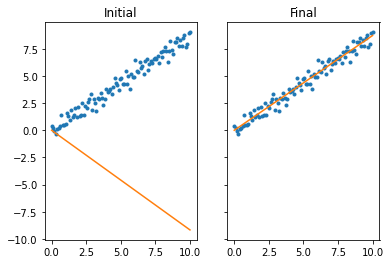

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

n_points = 100
noise_std = 0.5
X = np.linspace(0, 10, n_points)
slope = np.random.randn()
y = slope * X + noise_std * np.random.randn(n_points)

param = np.random.randn()

print(f'True slope: {slope:.3f}')
print(f'Initial param: {param:.3f}')

fig, axes = plt.subplots(1, 2, sharey=True)
axes = axes.flatten()

axes[0].plot(X, y, '.')
axes[0].plot(X, param * X)
axes[0].set_title('Initial')

n_iterations = 100
learning_rate = 1e-3
for _ in range(n_iterations):
  y_pred = param * X
  loss = np.mean((y_pred - y)**2)
  grad = 2 * np.mean((y_pred - y) * X)
  param -= learning_rate * grad

print(f'Final param: {param:.3f}')
axes[1].plot(X, y, '.')
axes[1].plot(X, param * X)
axes[1].set_title('Final')

plt.show()

### Step: Linear regression with automatic differentiation

Reimplement the code above performing the following changes:
* use `torch` tensors instead of `numpy` arrays;
* make `param` a `torch.Parameter`;
* instead of computing the gradient manually, you are to call `.backward()` on the loss. You can then update the parameter value using `param.data` and `param.grad`.
* after updating `param`, call `param.grad.zero_()` to reset the gradient to zero.

True slope: -1.696
Initial param: 0.773
Final param: -1.711


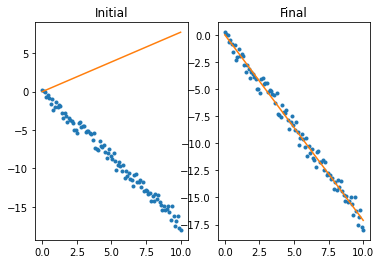

In [ ]:
#@title Reference { form-width:"100px"}

import torch
from torch.nn import Parameter
import matplotlib.pyplot as plt

n_points = 100
noise_std = 0.5
X = torch.linspace(0, 10, n_points)
slope = torch.randn(())
y = slope * X + noise_std * torch.randn(n_points)

param = Parameter(torch.randn(()))

print(f'True slope: {slope:.3f}')
print(f'Initial param: {param:.3f}')

fig, axes = plt.subplots(1, 2)
axes = axes.flatten()

axes[0].plot(X, y, '.')
axes[0].plot(X, (param * X).detach().numpy())
axes[0].set_title('Initial')

n_iterations = 100
learning_rate = 1e-3
for _ in range(n_iterations):
  y_pred = param * X
  loss = torch.mean((y_pred - y)**2)
  loss.backward()
  param.data -= learning_rate * param.grad
  param.grad.zero_()

print(f'Final param: {param:.3f}')
axes[1].plot(X, y, '.')
axes[1].plot(X, (param * X).detach().numpy())
axes[1].set_title('Final')

plt.show()

### Step: Logistic regression with neural network

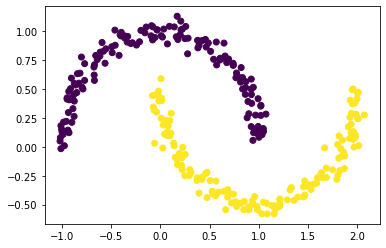

In [ ]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=300, noise=0.05)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=int)

plt.scatter(X[:, 0], X[:, 1], c=y)

Train a classifier for the classification dataset above. Your code should be similar to the linear regression example above; these are the main differences:
* Make a 2 hidden layer MLP (with Linear and ReLU) for your predictions;
* Instead of a squared loss, use a cross entropy loss;
* Update all the parameters of your network by iterating over them. You can iterate over all parameters of a `Module` by calling `.parameters()`.

Your goal is to get at least 99% accuracy.

In [ ]:
#@title Reference { form-width:"100px"}

import math
from torch.nn.functional import cross_entropy, softmax

hidden_size = 30

model = nn.Sequential(
    nn.Linear(2, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, 2),
)

n_epochs = 1000
batch_size = 128
learning_rate = 1e-2
n_batches = math.ceil(len(X) / batch_size)

accs = []
for epoch in range(n_epochs):
  for i in range(n_batches):
    batch_slice = slice(i*batch_size, (i+1)*batch_size)

    Xb = X[batch_slice] 
    yb = y[batch_slice]

    logits = model(Xb)
    loss = cross_entropy(logits, yb)
    loss.backward()
    for param in model.parameters():
      param.data -= learning_rate * param.grad
      param.grad.zero_()

  y_pred = model(X).argmax(-1)
  acc = torch.mean((y == y_pred).float())
  accs.append(acc)

print(f'final accuracy: {accs[-1]}')

final accuracy: 0.996666669845581


# Visualization

# Some TODOs:

* Improve instructions
    * I didn't think too much about how hard each part will be and how to make things smoother. There is probably a bunch of ways to make things more interesting.
    * Still to add or expand explanations on most steps
    * Computer vision literature is so vast. Lots of opportunities to add more stuff here.
* Add tests
    * Building blocks can be fuzz tested against original torch modules
    * There can also be tests against reference implementations
    * Not sure how to best test full ResNet other than by loading pretrained weights
* Add training section?
    * Curriculum includes on Tuesday: GPU, backward, training. Maybe we can add training it on MNIST, then on something like Imagenette or CIFAR-10. Maybe finetuning on something interesting?
* Add visualization section
    * As for now, week 1 Thursday will be a full day of visualization and interpretability. Still to figure out what that will be like
* Make sure reference code works (code works 100% fine locally, on colab there seems to have a mismatch vs. torch implementation (potentially from accumulating floating-point errors starting at conv2d. Might be version dependent.))
* Add bonus steps, e.g.
    * Groups and dilation for conv2d, maxpool2d
    * Bottleneck blocks for larger ResNets
* Convert this colab to google doc?